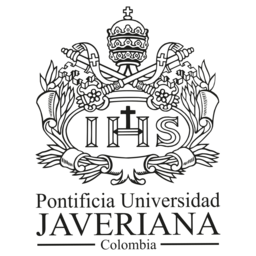

**Facultad de Ingeniería**

**Tópicos Avanzados de Analítica**

*Camila Andrea Arias Vargas*

*Felipe Clavijo Acosta*

*Joel Alfredo Márquez Álvarez*

*Juan Camilo Ramírez Restrepo*

*Juan Pablo Cuellar Solano*

## Song Embeddings - Skipgram Recommender

In this notebook, we'll use human-made music playlists to learn song embeddings. We'll treat a playlist as if it's a sentence and the songs it contains as words. We feed that to the word2vec algorithm which then learns embeddings for every song we have. These embeddings can then be used to recommend similar songs. This technique is used by Spotify, AirBnB, Alibaba, and others. It accounts for a vast portion of their user activity, user media consumption, and/or sales (in the case of Alibaba).

The [dataset we'll use](https://www.cs.cornell.edu/~shuochen/lme/data_page.html) was collected by Shuo Chen from Cornell University. The dataset contains playlists from hundreds of radio stations from around the US.

## Importing packages and dataset

In [2]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import Word2Vec
from urllib import request
import warnings
warnings.filterwarnings('ignore')

The playlist dataset is a text file where every line represents a playlist. That playlist is basically a series of song IDs.

In [3]:
# Obtener el archivo del conjunto de datos de listas de reproducción
data = request.urlopen('https://storage.googleapis.com/maps-premium/dataset/yes_complete/train.txt')

# Analizar el archivo del conjunto de datos de listas de reproducción. Saltar las dos primeras líneas, ya que
# solo contienen metadatos
lines = data.read().decode("utf-8").split('\n')[2:]

# Eliminar listas de reproducción con solo una canción
playlists = [s.rstrip().split() for s in lines if len(s.split()) > 1]

The `playlists` variable now contains a python list. Each item in this list is a playlist containing song ids. We can look at the first two playlists here:

In [4]:
# Imprimir la primera lista de reproducción
print('Playlist #1:\n ', playlists[0], '\n')

# Imprimir la segunda lista de reproducción
print('Playlist #2:\n ', playlists[1])


Playlist #1:
  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '2', '42', '43', '44', '45', '46', '47', '48', '20', '49', '8', '50', '51', '52', '53', '54', '55', '56', '57', '25', '58', '59', '60', '61', '62', '3', '63', '64', '65', '66', '46', '47', '67', '2', '48', '68', '69', '70', '57', '50', '71', '72', '53', '73', '25', '74', '59', '20', '46', '75', '76', '77', '59', '20', '43'] 

Playlist #2:
  ['78', '79', '80', '3', '62', '81', '14', '82', '48', '83', '84', '17', '85', '86', '87', '88', '74', '89', '90', '91', '4', '73', '62', '92', '17', '53', '59', '93', '94', '51', '50', '27', '95', '48', '96', '97', '98', '99', '100', '57', '101', '102', '25', '103', '3', '104', '105', '106', '107', '47', '108', '109', '110', '111', '112', '113', '25', '63', '62', '114', '115', '84', '116', '117',

## Training the Word2Vec Model
Our dataset is now in the shape the the Word2Vec model expects as input. We pass the dataset to the model.

In [5]:
# Crear un modelo Word2Vec a partir de las listas de reproducción
model = Word2Vec(playlists, vector_size=32, window=20, negative=50, min_count=1, workers=4)

The model is now trained. Every song has an embedding. We only have song IDs, though, no titles or other info. Let's grab the song information file.

## Song Title and Artist File
Let's load and parse the file containing song titles and artists

In [6]:
# Obtener el archivo con los datos de las canciones
songs_file = request.urlopen('https://storage.googleapis.com/maps-premium/dataset/yes_complete/song_hash.txt')

# Leer y decodificar el archivo, separando las líneas
songs_file = songs_file.read().decode("utf-8").split('\n')

# Crear una lista de canciones separando los campos por tabulaciones
songs = [s.rstrip().split('\t') for s in songs_file]

In [7]:
# Crear un DataFrame a partir de la lista de canciones con columnas específicas
songs_df = pd.DataFrame(data=songs, columns=['id', 'title', 'artist'])

# Establecer la columna 'id' como el índice del DataFrame
songs_df = songs_df.set_index('id')

In [8]:
# Mostrar las primeras filas del DataFrame de canciones
songs_df.head()

,title,artist
id,,
0,Gucci Time (w\/ Swizz Beatz),Gucci Mane
1,Aston Martin Music (w\/ Drake & Chrisette Mich...,Rick Ross
2,Get Back Up (w\/ Chris Brown),T.I.
3,Hot Toddy (w\/ Jay-Z & Ester Dean),Usher
4,Whip My Hair,Willow


### Exercise:

Build visualization for the embeddings of the song recommender.

In [27]:
from collections import Counter

# Contar la frecuencia de cada canción en todas las listas de reproducción
all_songs = [song for playlist in playlists for song in playlist]
song_counts = Counter(all_songs)

# Obtener las 8 canciones más frecuentes
top8_songs = song_counts.most_common(8)

# Crear un DataFrame a partir de las 8 canciones más frecuentes
top8 = pd.DataFrame(top8_songs, columns=['song_id', 'count'])


In [20]:
# Mostrar las primeras filas del DataFrame de canciones
top8.head()

,song_id,count
0,20065,5593
1,5,5041
2,46,4497
3,7233,3828
4,20627,3767


In [28]:
# guarda los valores de song_id de la tabla top8 en una lista
song_id_list = top8['song_id'].tolist()


In [29]:
# Definir los IDs de canciones de interés
keys = song_id_list  # Lista de IDs de canciones
# Nota: Cada número en 'keys' representa un ID de canción

# Inicializar las listas que almacenarán los embeddings y las palabras similares
embedding_clusters = []  # Lista para almacenar los embeddings de las palabras más similares
word_clusters = []       # Lista para almacenar las palabras más similares

# Iterar sobre cada ID de canción
for word in keys:
    embeddings = []  # Lista temporal para almacenar los embeddings de las palabras similares a 'word'
    words = []       # Lista temporal para almacenar las palabras similares a 'word'

    # Obtener las 30 palabras más similares a la palabra clave actual junto con sus similitudes
    similar_words = model.wv.most_similar(word, topn=30)

    # Iterar sobre cada palabra similar y su similitud
    for similar_word, _ in similar_words:
        words.append(similar_word)           # Agregar la palabra similar a la lista temporal
        embeddings.append(model.wv[similar_word])  # Agregar el embedding de la palabra similar

    # Agregar el conjunto de embeddings y palabras al clúster correspondiente
    embedding_clusters.append(embeddings)  # Guardar los embeddings de las palabras similares
    word_clusters.append(words)            # Guardar las palabras similares


In [30]:
# Imprimir el primer embedding del primer clúster
print("Embedding cluster (primer vector de la primera palabra similar):", embedding_clusters[0][0])

# Imprimir los primeros dos clústeres de palabras
print("Word clusters (primeros dos clústeres de palabras similares):", word_clusters[:2])


Embedding cluster (primer vector de la primera palabra similar): [-3.0859532  -3.1509297   1.4166771   0.6034191   1.0598152  -3.490343
 -3.9890807  -1.1841229  -3.7459505   0.6016107  -0.45142794 -0.0892329
  3.696146   -0.9510252   0.9486078  -1.3160572   1.6051968   0.01138037
  0.41521806  0.4532909   3.0913255   1.8008063  -3.2564788   1.2971946
 -0.45894542 -0.7655073   3.3950076  -0.3240884   1.4584364   4.366802
  2.5963888   0.59084135]
Word clusters (primeros dos clústeres de palabras similares): [['5', '77', '20627', '20068', '1', '27076', '19477', '26735', '27132', '53', '20070', '20634', '292', '20622', '20620', '22390', '22475', '20052', '34677', '57', '27071', '225', '344', '41470', '99', '63061', '20151', '1155', '17', '20632'], ['20068', '20065', '20627', '19477', '27076', '77', '26735', '292', '20634', '27132', '20620', '1', '20622', '20052', '53', '20151', '225', '25', '344', '57', '17', '1155', '20632', '99', '20070', '242', '34677', '20646', '22390', '27082']]


In [34]:
from sklearn.manifold import TSNE
import numpy as np

# Convertir la lista de embedding clusters a un array de NumPy para manipulación más eficiente
embedding_clusters = np.array(embedding_clusters)

# Obtener las dimensiones del array: n = número de palabras clave (o clusters), m = número de palabras similares, k = dimensiones del embedding
n, m, k = embedding_clusters.shape

# Inicializar el modelo t-SNE con las configuraciones dadas
tsne_model_en_2d = TSNE(perplexity=5, n_components=2, init='pca', n_iter=1500, random_state=920311)

# Aplicar t-SNE a los embeddings:
# 1. Primero aplanamos el array (n * m, k) para que t-SNE funcione con datos en alta dimensión.
# 2. Luego transformamos los datos con t-SNE y los devolvemos a la forma original (n clusters, m palabras, 2 dimensiones).
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

# Ahora 'embeddings_en_2d' contiene las representaciones 2D de las palabras similares para cada palabra clave (lista para ser visualizada).


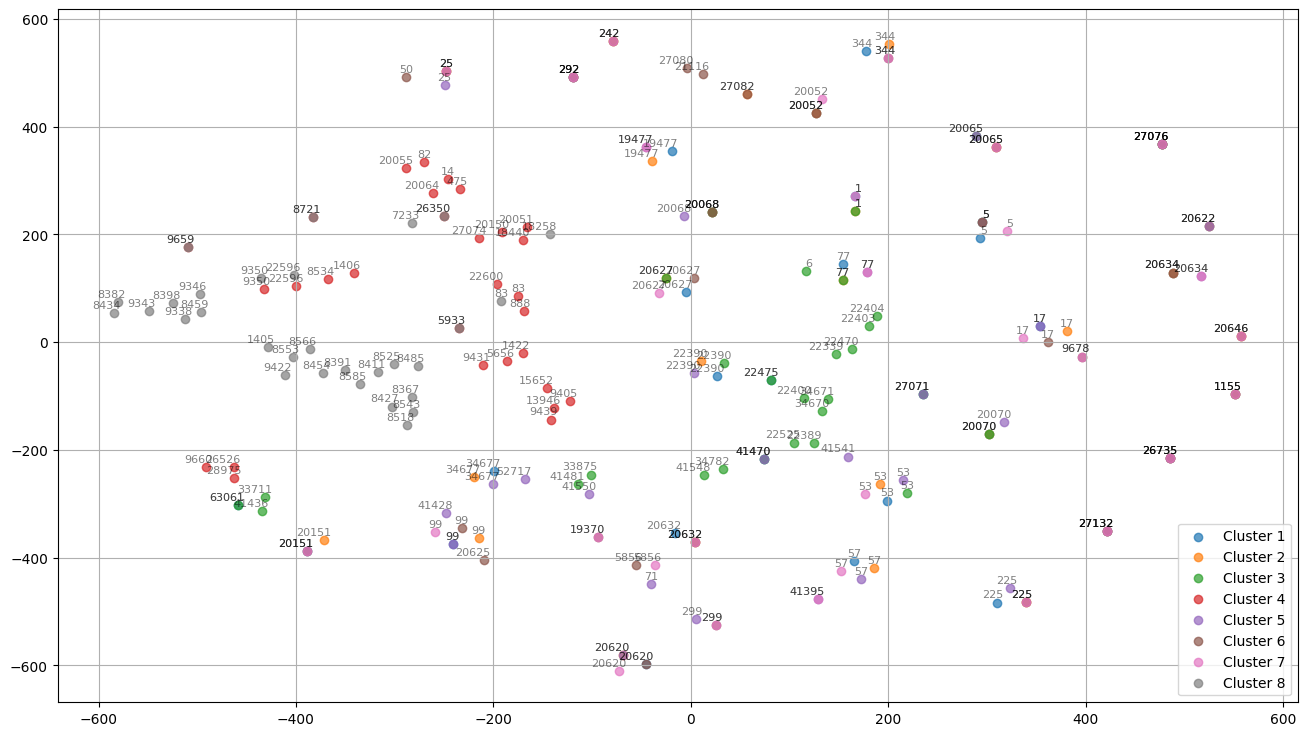

In [35]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline

# Función para crear gráficos 2D de embeddings usando Matplotlib
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))  # Configurar tamaño del gráfico

    # Iterar sobre cada conjunto de etiquetas, embeddings y palabras
    for label, embeddings, words in zip(labels, embedding_clusters, word_clusters):
        x = embeddings[:, 0]  # Coordenada X
        y = embeddings[:, 1]  # Coordenada Y
        plt.scatter(x, y, alpha=a, label=label)  # Graficar los puntos
        # Anotar cada punto con la palabra correspondiente
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)

    plt.legend(loc=4)  # Mostrar leyenda en la esquina inferior derecha
    plt.grid(True)  # Activar la cuadrícula
    plt.show()  # Mostrar el gráfico

# Definir etiquetas para los clusters
new_labels = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5", "Cluster 6", "Cluster 7", "Cluster 8"]

# Llamar a la función para generar el gráfico con las nuevas etiquetas
tsne_plot_similar_words(new_labels, embeddings_en_2d, word_clusters)

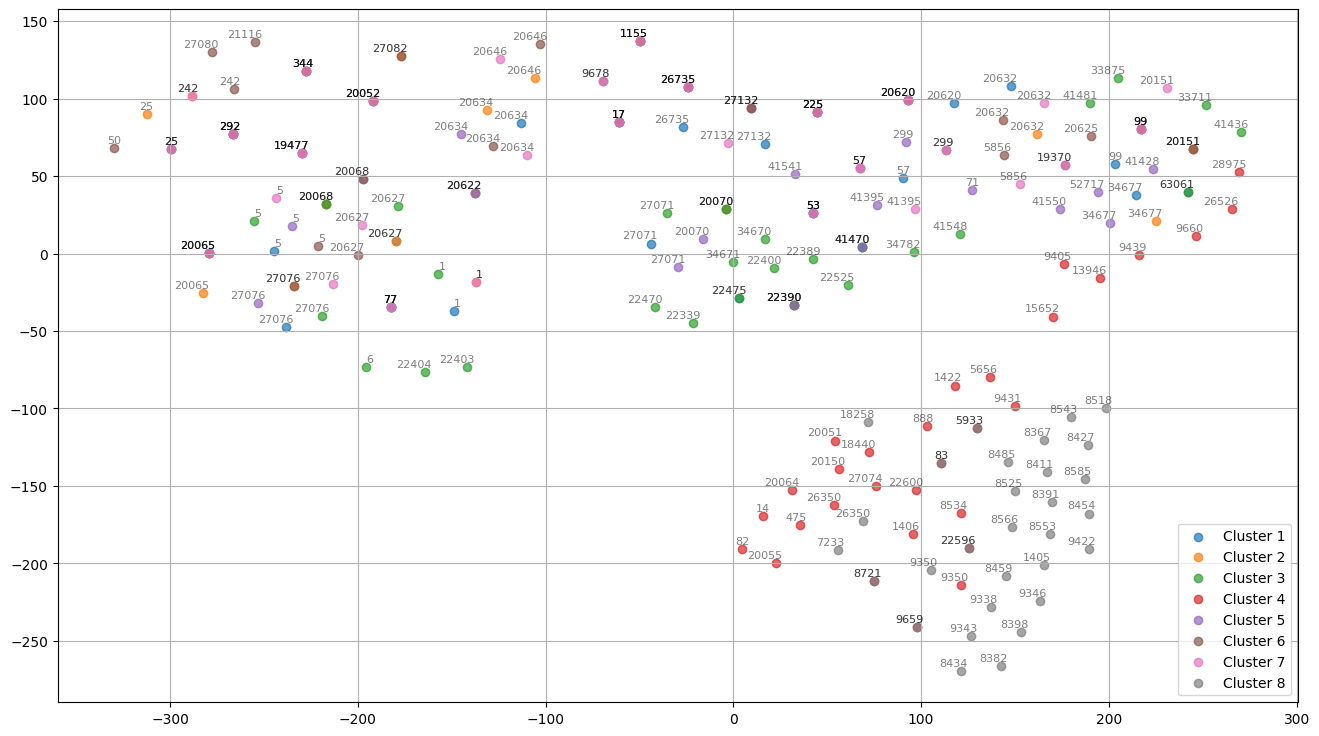

In [36]:
# Inicializar el modelo t-SNE con los parámetros especificados
tsne_model_en_2d = TSNE(perplexity=50, n_components=2, init='pca', n_iter=1500, random_state=920311)

# Aplicar t-SNE a los embeddings y reformatear a 2D
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

# Visualizar los embeddings en 2D con etiquetas
tsne_plot_similar_words(new_labels, embeddings_en_2d, word_clusters)  # Usando new_labels
# o
# tsne_plot_similar_words(words_vocab_without_sw, embeddings_en_2d, word_clusters)  # Usando words_vocab_without_sw si está definida